# An example for troubleshooting

The goal of this notebook, is to demonstrate two different methods for creating `s_net` and `t_net` for a Boltzmann generator. We will compare the performance of the models based on these two different methods and find out why the second method of creating `s_net` and `t_net` is not as good as the other.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import warnings
import torch 
from torch import distributions
from torch import nn
from torch.utils import data
from tqdm.auto import tqdm
warnings.filterwarnings('ignore')
sys.path.insert(1, '../')  # so the system can locate the library folder
sys.path.insert(1, '../Library')
import Library.potentials as potentials
import Library.generator as generator
import Library.sampling as sampling
import Library.training as training

## 1. Generation of the training dataset

**Relevant modules in `Library`: `potential.py` and `sampling.py`**

As shown below, the samples (`x_samples`) for training the Boltzmann generator are drawn from two Monte Carlo simulations of a particle starting from the left local minimum and the right local minimum, respectively. A Boltzmann generator learns the mapping between the configuration space and the latent space. Specifically, the figure below shows the samples in the latent space.

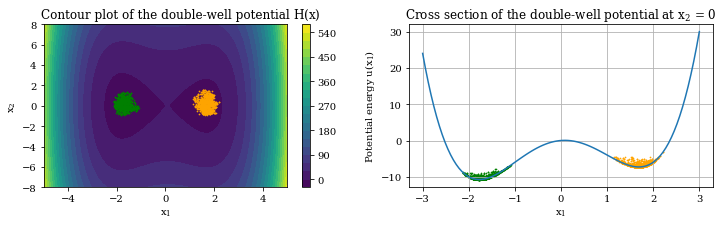

In [2]:
doublewell = potentials.DoubleWellPotential(a=1, b=6, c=1, d=1)  #  defaults = {"a": 1, "b": 6, "c": 1, "d": 1}
MCsampler1 = sampling.MetropolisSampler(doublewell, doublewell.min_left)
MCsampler1.run(doublewell.min_left, 1000)
samples1 = MCsampler1.xtraj

MCsampler2 = sampling.MetropolisSampler(doublewell, doublewell.min_right)
MCsampler2.run(doublewell.min_right, 1000)
samples2 = MCsampler2.xtraj

fig = doublewell.plot_samples(samples1)
fig = doublewell.plot_samples(samples2, fig, 'orange')

x_samples = np.concatenate((samples1, samples2))  # the training dataset
np.random.shuffle(x_samples) # shuffle rows of data

## 2. Construction of a Boltzmann generator

**Revelant modules in `Library`: `generator.py`**

<center><img src=https://i.imgur.com/qgPKzrn.png width=600></center>
</br>

The architecture of a Boltzmann generator is shown above. A boltzmann generator is able to transform a probability distribution in the configuration space ($p_{x}(x)$) to the probability distribution in the latent space. The probability distribution in the configuration space is Boltzmann distribution, and the one in the latent space is a Gaussian distribution. At this point, we don't know how the Boltzmann distribtution looks like, but we can draw samples from Boltzmann distribution by performing MC simulations in the configuraiton space as shown in Section 1. The goal of a Boltzmann generator, is to learn the transformation between the Boltzmann distribution in the configuration space and the Gaussian distribution in the latent space. The transformation from $x$ to $z$ is done be what we called as an inverse generator ($F_{xz}$), while the transfomration from $z$ to $x$ is done by a generator ($F_{zx}$).

A Boltzmann generator is an application of Real value NVP (non volume preserving transformation, which is a kind of flow-based generative models). In our case here, we want to create a Boltzmann generator composed of two NVP blocks that contain two affine coupling layers in each of them. An affine coupling layer performs affine transformation, i.e. shift-and-translating transformation. It is composed of two neural networks, one of which is for scaling (`s_net`) and the other is for translating (`t_net`). In our case here, both `s_net` and `t_net` are composed of three layers. 

To build a Boltzmann generator, we first have to decide the following parameters and create `s_net` and `t_net`. Below we will build `s_net` and `t_net` using the **first method**. But before that, let's first fix the random seed that it would be easier for us to compare the results with teh second method later.

In [3]:
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

n_blocks = 3     # number of NVP blocks
dimension = 2    # dimensionality of the probability distributios (in real sapce and latent space)
n_nodes = 100   # number of nodes in each hidden layer
n_layers = 3     # number of hidden layers (actually not used in the first method)
n_iterations = 200
batch_size = 1000
LR = 0.001     # learning rate
prior_sigma = 1  # the standard deviation (sigma) of the Gaussian prior distribution in the latent space

s_net = nn.Sequential(nn.Linear(2, n_nodes), nn.ReLU(), nn.Linear(n_nodes, n_nodes), nn.ReLU(), nn.Linear(n_nodes, 2), nn.Tanh())
t_net = nn.Sequential(nn.Linear(2, n_nodes), nn.ReLU(), nn.Linear(n_nodes, n_nodes), nn.ReLU(), nn.Linear(n_nodes, 2))

In [13]:
model_test1.s

ModuleList(
  (0): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=2, bias=True)
    (5): Tanh()
  )
  (1): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=2, bias=True)
    (5): Tanh()
  )
  (2): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=2, bias=True)
    (5): Tanh()
  )
  (3): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=2, bias=Tr

Here is how `s_net` and `t_net` look like:

In [4]:
s_net

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=2, bias=True)
  (5): Tanh()
)

In [5]:
t_net

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=2, bias=True)
)

Then, we create `mask` (for alternating the shifting and translating within one NVP block so that different dimensions of data are trained) and `prior` (the Gaussian distribution in the latent space) and use them to initizlie `RealNVP` class to build the model, a Boltzmann generator. (At this point, the network has not been trained at all). Here I print first five weights of the first layer of `s_net()` and `t_net()` to compare later with the second method.

In [6]:
mask = torch.from_numpy(np.array([[0, 1], [1, 0]] * n_blocks).astype(np.float32)) 
prior = distributions.MultivariateNormal(torch.zeros(dimension), torch.eye(dimension) * prior_sigma) 
model_test1 = generator.RealNVP(s_net, t_net, mask, prior, doublewell, (2,))

s =  tensor([[ 0.3643, -0.3121],
        [-0.1371,  0.3319],
        [-0.6657,  0.4241],
        [-0.1455,  0.3597],
        [ 0.0983, -0.0866]], grad_fn=<SliceBackward>)
t =  tensor([[ 0.5404,  0.3247],
        [-0.3355, -0.1006],
        [-0.6046, -0.2065],
        [ 0.1116,  0.6818],
        [-0.6950, -0.1588]], grad_fn=<SliceBackward>)


## 3. Training a Boltzman generator

**Revelant modules in `Library`: `generator.py`**

Having a training dataset (`x_samples`) and a built generator, we are ready to train the generator (ajust the parameters in `s_net` and `t_net`). To do that, we first have to preprocessing `x_samples` by extracting a batch of data as follows:

In [7]:
training_set = x_samples.astype('float32')
subdata = data.DataLoader(dataset=training_set, batch_size=batch_size)  # use trainloader.dataset to check the data
batch = torch.from_numpy(subdata.dataset)   # note that subdata.dataset is a numpy array

Then, we choose Adam as the optimizer for the gradient descent and start training!

ML loss: -1.461066365242004463


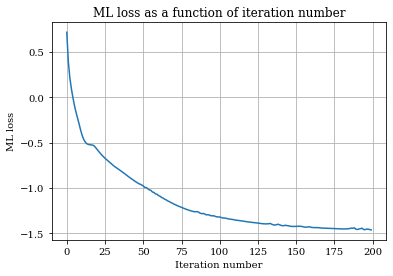

In [8]:
optimizer = torch.optim.Adam([p for p in model_test1.parameters() if p.requires_grad==True], lr=LR) 

loss_list = []
for i in tqdm(range(n_iterations)):
    loss = model_test1.loss_ML(batch)
    loss_list.append(loss.item())  # convert from 1-element tensor to scalar

    # start training
    optimizer.zero_grad() # Set grads to zero so that PyTorch will not accumulate gradients during backpropagation
    loss.backward(retain_graph=True)
    optimizer.step()   # check https://tinyurl.com/y8o2y5e7 for more info
    tqdm.write("ML loss: %s" % loss.item(), end="\r")

plt.figure()
plt.plot(range(n_iterations), loss_list)
plt.xlabel('Iteration number')
plt.ylabel('ML loss')
plt.title('ML loss as a function of iteration number')
plt.grid()

As the training dataset is actually pretty small in this demonstrative case, it should take no longer than three minutes to finish the training. As a result, 200 iterations are already sufficent to converge the loss function. At this point, the generator is trained, which means that ideally it should be able to generate samples in the configuration space which approximates the Boltzmann distribution. To do that, we first load `binormal_contour` so that we can plot the contour of a Gaussian in the latent space.

In [9]:
from scipy.stats import multivariate_normal
def binormal_contour():
    x, y = np.mgrid[-3:3:.01, -3:3:.01]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    rv = multivariate_normal([0, 0], [[1, 0], [0, 1]])
    
    plt.contourf(x, y, rv.pdf(pos), 20)
    plt.xlabel('$ z_{1} $')
    plt.ylabel('$ z_{2} $')
    plt.title('Bivariate normal distribution')
    clb = plt.colorbar()
    clb.ax.set_title(r'$P(z)$')
    
    ax = plt.gca()
    ax.set_aspect('equal')

Then, we can show the process of samples going back and forth between different spaces as below:

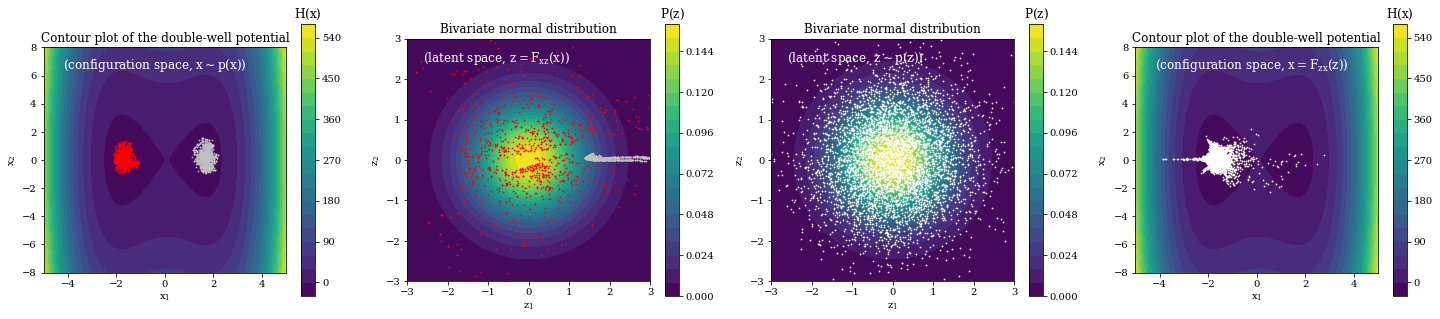

In [10]:
fig = plt.subplots(1, 4, figsize=(25, 5))

# First subplot: samples drawn from the configuration space
plt.subplot(1, 4, 1)
doublewell.plot_FES()
plt.scatter(samples1[:, 0], samples1[:, 1], color='red', s=0.5)
plt.scatter(samples2[:, 0], samples2[:, 1], color='silver', s=0.5)
plt.annotate('(configuration space, $ x \sim p(x) $)', xy=(0, 0), xytext=(-4.2, 6.5), color='white', size='12')
ax = plt.gca()
ax.set_aspect(0.58)


# Second subplot: transform configuration samples to latent samples using a trained inversed generator
z1, _, z1_list = model_test1.inverse_generator(torch.from_numpy(samples1.astype('float32')), process=True)
z2, _, z2_list = model_test1.inverse_generator(torch.from_numpy(samples2.astype('float32')), process=True)
z1 = z1.detach().numpy()
z2 = z2.detach().numpy()

plt.subplot(1, 4, 2)
binormal_contour()
plt.scatter(z1[:, 0], z1[:, 1], color='red', s=0.5)
plt.scatter(z2[:, 0], z2[:, 1], color='silver', s=0.5)
plt.annotate('(latent space, $ z = F_{xz}(x) $)', xy=(0, 0), xytext=(-2.625, 2.4375), color='white', size='12')
plt.xlim([-3, 3])
plt.ylim([-3, 3])


# Third subplot: draw 2000 samples from the prior Gaussian distribution
z_samples = prior.sample_n(5000)
z_samples = z_samples.detach().numpy()  

plt.subplot(1, 4, 3)
binormal_contour()
plt.scatter(z_samples[:, 0], z_samples[:, 1], color='white', s=0.5)
plt.annotate('(latent space, $ z \sim p(z) $)', xy=(0, 0), xytext=(-2.625, 2.4375), color='white', size='12')
plt.xlim([-3, 3])
plt.ylim([-3, 3])

# fourth subplot: transform the latent samples back to the configuration space using a generator
x_generated, _, x_list = model_test1.generator(torch.from_numpy(z_samples), process=True)
x_generated = x_generated.detach().numpy()

plt.subplot(1, 4, 4)
doublewell.plot_FES()
plt.scatter(x_generated[:, 0], x_generated[:, 1], color='white', s=0.5)
plt.annotate('(configuration space, $ x = F_{zx}(z) $)', xy=(0, 0), xytext=(-4.2, 6.5), color='white', size='12')
plt.xlim([-5, 5])
plt.ylim([-8, 8])
ax = plt.gca()
ax.set_aspect(0.58)

Here are some notes above the four figures shown above:
- **First figure**: the samples (extracted from MC simulations) in the latent space.
- **Second figure**: the samples (drawn from the Boltzmann distribution) in the configuration space are transformed to the latent space (a Gaussian distribution) by an inverse generator. 
- **Third figure**: to generate/predice new samples in configuraiton space, we first draw samples from a Gaussian distribution in the latent space
- **Fourth figure**: the samples drawn from the Gaussian in the latent sapce are mapped back to the configuration space. As shown, the generated sampes exhibit a similar pattern as the first figure, which means that the majority of the samples are mapped to the wells. **This shows that our Boltzmann generator here is successfully trained so it is able to generate representative samples.**

## 4. The second method of building `s_net` and `t_net`

**Revelant modules in `Library`: `generator.py` and `training.py`**

As shown in the previous section, the drawback of the first method is that we have to manually hard-code the depth of `s_net` and `t_net`. Therefore, here we developed `training.py` to automate the whole process of building a Boltzmann generator, which also allows automatic building of `s_net` and `t_net` given required parameters. With, `training.py`, we can repeat the process above by the following code. (Again, we fix the random seed at 1.)

s =  tensor([[ 0.3643, -0.3121],
        [-0.1371,  0.3319],
        [-0.6657,  0.4241],
        [-0.1455,  0.3597],
        [ 0.0983, -0.0866]], grad_fn=<SliceBackward>)
t =  tensor([[ 0.5404,  0.3247],
        [-0.3355, -0.1006],
        [-0.6046, -0.2065],
        [ 0.1116,  0.6818],
        [-0.6950, -0.1588]], grad_fn=<SliceBackward>)


Total loss: -1.461066365242004463


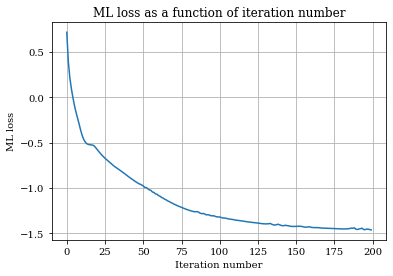

In [11]:
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

params_ML = {"n_blocks": 3, "dimension": 2, "n_nodes": 100, "n_layers": 3,
               "n_iterations": 200, "batch_size": 1000, "LR": 0.001, "prior_sigma": 1}

BoltzmannGenerator_ML = training.BoltzmannGenerator(model_params=params_ML)
model_test2 = BoltzmannGenerator_ML.build(doublewell)
BoltzmannGenerator_ML.train(model_test2, x_samples=x_samples)
loss = BoltzmannGenerator_ML.loss_list
    
# plot the loss function as a function of iteration
plt.figure()
plt.plot(range(len(loss)), loss)
plt.xlabel('Iteration number')
plt.ylabel('ML loss')
plt.title('ML loss as a function of iteration number')
plt.grid()

As shown above, the class `BoltzmannGenerator` in `training.py` takes in the parameters as a dictionary. The methods involed in creating `s_net` and `t_net` include `affine_layers`, `build_networks` and `build`. As can be seen in the codes in the `Libraray`, `affine_layers` returns a list of layers, then `build_networks` uses `affine_layers`, append `Tanh()` to the layers list for `s_net`, and apply `nn.Sequential` to make `s_net` and `t_net` (as attributes of the class). However, as shown above, the weights of `s_net` and `t_net` are clearly different from the first method, even if the random seed is fixed. In addition, the curve of loss function as a function of iteration number drops less smoothly compared with the one produced in the first method. 

To see if the model using `s_net` and `t_net` havs similar performance as the model in the first method, similarly, we plot the figures as below:

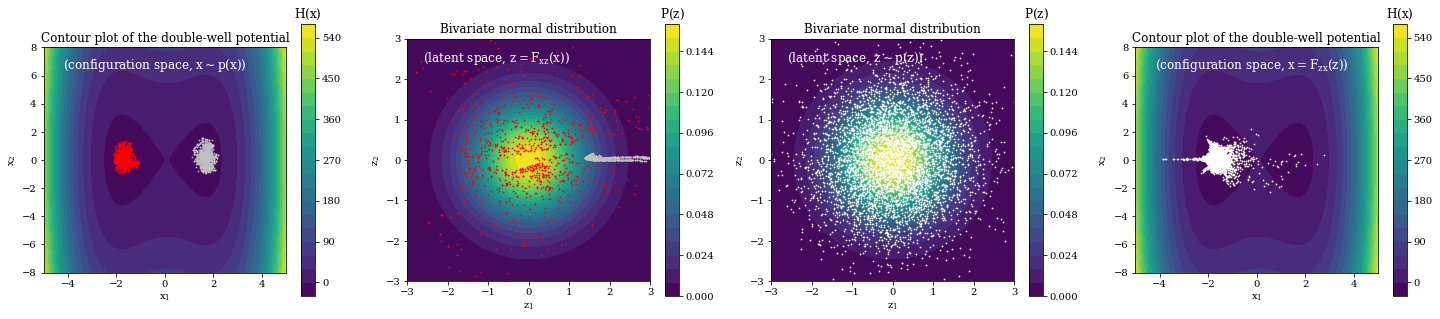

In [12]:
fig = plt.subplots(1, 4, figsize=(25, 5))

# First subplot: samples drawn from the configuration space
plt.subplot(1, 4, 1)
doublewell.plot_FES()
plt.scatter(samples1[:, 0], samples1[:, 1], color='red', s=0.5)
plt.scatter(samples2[:, 0], samples2[:, 1], color='silver', s=0.5)
plt.annotate('(configuration space, $ x \sim p(x) $)', xy=(0, 0), xytext=(-4.2, 6.5), color='white', size='12')
ax = plt.gca()
ax.set_aspect(0.58)


# Second subplot: transform configuration samples to latent samples using a trained inversed generator
z1, _, z1_list = model_test2.inverse_generator(torch.from_numpy(samples1.astype('float32')), process=True)
z2, _, z2_list = model_test2.inverse_generator(torch.from_numpy(samples2.astype('float32')), process=True)
z1 = z1.detach().numpy()
z2 = z2.detach().numpy()

plt.subplot(1, 4, 2)
binormal_contour()
plt.scatter(z1[:, 0], z1[:, 1], color='red', s=0.5)
plt.scatter(z2[:, 0], z2[:, 1], color='silver', s=0.5)
plt.annotate('(latent space, $ z = F_{xz}(x) $)', xy=(0, 0), xytext=(-2.625, 2.4375), color='white', size='12')
plt.xlim([-3, 3])
plt.ylim([-3, 3])


# Third subplot: draw 2000 samples from the prior Gaussian distribution
z_samples = prior.sample_n(5000)
z_samples = z_samples.detach().numpy()  

plt.subplot(1, 4, 3)
binormal_contour()
plt.scatter(z_samples[:, 0], z_samples[:, 1], color='white', s=0.5)
plt.annotate('(latent space, $ z \sim p(z) $)', xy=(0, 0), xytext=(-2.625, 2.4375), color='white', size='12')
plt.xlim([-3, 3])
plt.ylim([-3, 3])

# fourth subplot: transform the latent samples back to the configuration space using a generator
x_generated, _, x_list = model_test2.generator(torch.from_numpy(z_samples), process=True)
x_generated = x_generated.detach().numpy()

plt.subplot(1, 4, 4)
doublewell.plot_FES()
plt.scatter(x_generated[:, 0], x_generated[:, 1], color='white', s=0.5)
plt.annotate('(configuration space, $ x = F_{zx}(z) $)', xy=(0, 0), xytext=(-4.2, 6.5), color='white', size='12')
plt.xlim([-5, 5])
plt.ylim([-8, 8])
ax = plt.gca()
ax.set_aspect(0.58)

As a result, the performance of the second model is apparently poor, since it failed to generate samples in the well of the right. Given that `training.py` is basically doing what was done in the first method, it is really confusing that the second model with exactly the same set of parameters would have such poor performance. 

Above is the reproduction of the problem, which is the discrepancy between two different methods for creating `s_net` and `t_net`. Let me know if you need more expanation or information about the model! **Thank you very much for your help!!**